In [2]:
# Import public modules
import torch
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

# Import custom modules
from src import encodings
from src import managers
from src import utils
from src.models import discrete_1D_models

In [3]:
## Define some utility functions
def plot_data_distr(x, title=None, ax=None, label_symbols=None, color='hotpink', bar_label=None):
    """ Plot the data distribution. """
    # Define some plot specs
    alpha_plot = 0.5

    # Define default label symbols
    if label_symbols is None:
        label_symbols = ['A', '<MASK>', 'B']

    show_fig = False
    if ax is None:
        show_fig = True
        plt.figure(figsize=(6, 6))
        ax = plt.gca()

    # # Determine the number of labels
    # num_labels = np.max(x)-np.min(x)+1

    # Determine and plot the distribution
    pos, counts = np.unique(x, return_counts=True)
    counts = counts/np.sum(counts) # Normalize the counts
    plt.bar(pos, counts, align='center', color=color, alpha=alpha_plot, label=bar_label)

    # Set plot specs
    if title is not None:
        ax.set_title(title)

    ax.set_xticks(list(range(len(label_symbols))))
    ax.set_xticklabels(label_symbols)
    ax.set_xlim([-0.5, len(label_symbols)-0.5])
    ax.set_ylim([0, 1])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel('Density')

    if show_fig:
        plt.show()

[0 2 2 0 0 0 0 2 0 2]


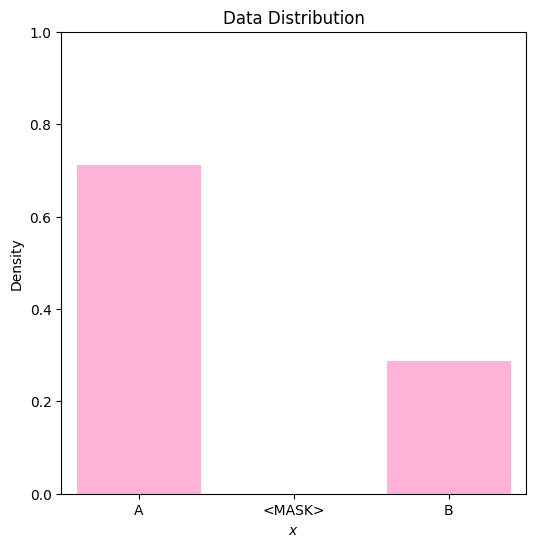

In [4]:
######################################
### Generate 1-categorical data
######################################
# Reload custom modules
reload(encodings)


# Define the number of datapoints
num_datapoints = 1000

# Define the label symbols
label_symbols = ['A', '<MASK>', 'B']

# Sample data into two classes (i.e. their labels) 'A' (index 0) and 'B' (index 2)
# while defining the probability to sample class 'A' (i.e. prob_B=1-prob_A)
np.random.seed(42)
prob_A = 0.7
x_data = np.random.choice([0, 2], size=(num_datapoints,), p=[prob_A, 1-prob_A])
print(x_data[:10])

# Plot the data distribution
plot_data_distr(x_data, title='Data Distribution', label_symbols=label_symbols)

Training the 'denoising' model for '100' epochs.
[0] 14832534.0


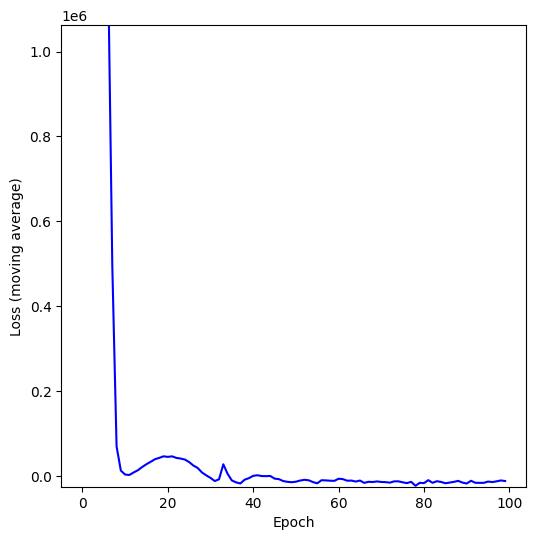

Last epoch loss (moving average): -11139.0673828125

----------------------------------------------------------------------------------------------------

Training the 'property' model for '200' epochs.
[0] 1292.3900146484375
[100] 227.4745330810547


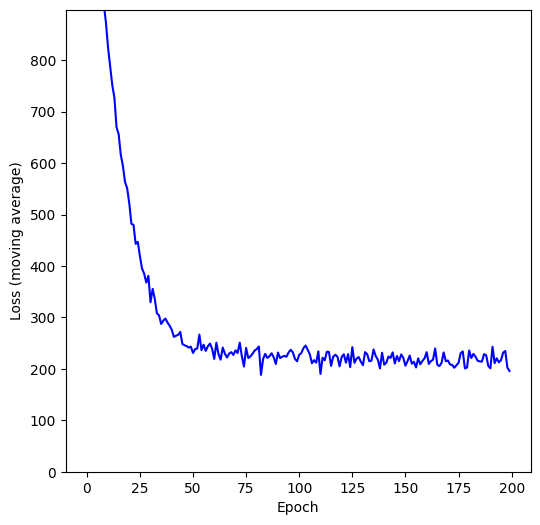

Last epoch loss (moving average): 195.84756469726562

----------------------------------------------------------------------------------------------------


Generation done


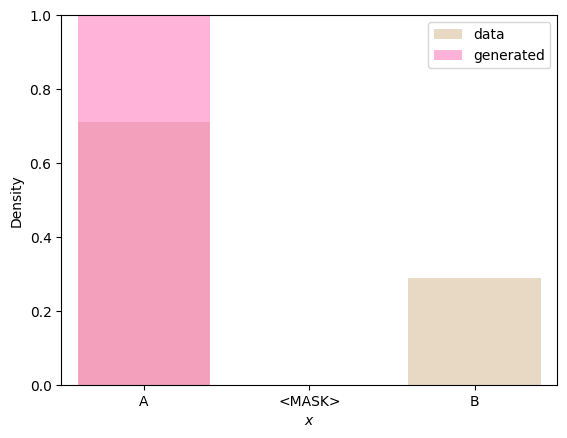

In [9]:
# Reload custom modules
reload(utils)
reload(managers)
reload(discrete_1D_models)

# Use guided diffusion?
use_guided_diffusion = True

# Use an unconditional denoising model
torch.random.manual_seed(20)
denoising_model = discrete_1D_models.DenoisingModel(x_enc_dim=3, t_dim=1, lat_dim=50)

# Define an optimizer for the model parameters of the denoising model
denoising_optimizer = torch.optim.Adam(denoising_model.parameters(), lr=0.01) #0.01

# Differ cases where we wanna use guided diffusion or not
if use_guided_diffusion:
    # Use guided diffusion
    # Initialize the property model if we want to use guided diffusion
    torch.random.manual_seed(21)
    property_model = discrete_1D_models.PropertyModel(x_enc_dim=3, t_dim=1, y_dim=3, lat_dim=10)

    # Define an optimizer for the model parameters of the property model (used for guidance)
    property_optimizer  = torch.optim.Adam(property_model.parameters(), lr=0.01) #0.01

    # Define a diffusion manager object
    torch.random.manual_seed(72)
    diffusion_manager = managers.Discrete1DDiffusionManager(denoising_model, denoising_optimizer, prob_vec_1=[0, 1, 0], gamma_scale=2, property_model=property_model, property_optimizer=property_optimizer) #2
else:
    # Do not use guided diffusion
    # Define a diffusion manager object
    torch.random.manual_seed(72)
    diffusion_manager = managers.Discrete1DDiffusionManager(denoising_model, denoising_optimizer, prob_vec_1=[0, 1, 0], gamma_scale=2) #2
    
# Show the noise schedule
#diffusion_manager.show_noise_schedule()

# # Sample forward in time
# plot_data_distr(x_data, title='Data Distribution', label_symbols=label_symbols)

# torch.random.manual_seed(42)
# z_t = diffusion_manager.forward_sample_z_t(torch.tensor(x_data), 1)
# plot_data_distr(z_t, title='Data Distribution', label_symbols=label_symbols)

# Calculate the diffusion loss
# batch_data = {'x': torch.tensor(x_data[:2]).reshape(-1, 1)}
# torch.random.manual_seed(43)
# diffusion_manager.diffusion_batch_loss(batch_data)

##########################################################################################################
### 4) Model training
##########################################################################################################
# Define the training dataset and a dataloader
X_data = x_data.reshape(-1, 1)
y_data = x_data

train_dataset    = utils.DictDataset(x=torch.tensor(X_data, dtype=torch.int), y=torch.tensor(y_data, dtype=torch.int))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=X_data.shape[0], shuffle=True)

# Train the denoising model
torch.random.manual_seed(43)
diffusion_manager.train(train_dataloader, which_model='denoising', num_epochs=100)
print()
print('-'*100)
print()

# Train the property model if we use guided diffusion
if use_guided_diffusion:
    diffusion_manager.train(train_dataloader, which_model='property', num_epochs=200)

print()
print('-'*100)
print()

# Generate novel points
diffusion_manager._debug = False
x_generated = diffusion_manager.generate(batch_size=100, num_integration_points=100, random_seed=24, y=0, guide_temp=1)
print()
print("Generation done")

# Overplot the data and generated distributions
plt.figure()
ax = plt.gca()

# Plot the data distribution
plot_data_distr(x_data, ax=ax, label_symbols=label_symbols, color='tan', bar_label='data')

# Plot the data distribution
plot_data_distr(x_generated, ax=ax, label_symbols=label_symbols, color='hotpink', bar_label='generated')

plt.legend()
plt.show()
